# Regression analysis of Seoul bike sharing dataset.

Author: Ulysse Zampogna <br>

Data: [Link](https://archive-beta.ics.uci.edu/ml/datasets/seoul+bike+sharing+demand) <br>
Source: UC Irvine - Machine Learning Repository

Objective:
* Predict the number of shared bike used per day based on series of variables.
* Assess how well does the final regression model explain/capture the variability of the bike rental service in Seoul.

---
## Executive summary:

This notebook demonstrates that the Rented Bike count in Seoul can be expressed and predicted based on a Multiple Linear Regression model. 

In terms of pure predictive power, the final linear model proposed captures 70% of the variability in the number of bike rented per day. After a careful model evaluation, a few signs show that the model can be improved - especially for days with low demand.

After analyzing the features importance, we know that the number of rented bike is highly influenced by the hour of day, month of the year and temperature. Other features related to the meteorological conditions are also taken into account. 

Thanks to a number of insights collected by analyzing the model, we can extrapolate a few hypothesis. For example, the rental service shows a strong demand on typical office hours peaks. Hence, the service is used by commuters. Based on this, we could propose further investigations on customer satisfication dedicated towards commuters. In parallel, a market analysis could focus on the value proposition for other customer segments like tourists.

---
## Table of contents 

1. Import  
2. Exploratory data analysis (EDA)<br>
   2.1 Basic info & stats<br>
   2.2 Numerical variables<br>
   2.3 Categorical variables<br>
   2.4 Null values<br>
   2.5 Outliers<br>
   2.6 Multicollinearity<br>
   2.7 Distributions<br>
3. Feature engineering<br>
   3.1 Train/Test split<br>
   3.2 Add dates features: Year, Month, Day of Week<br>
   3.3 Pipeline creation<br>
   3.4 Pipeline testing<br>
4. Modelling<br>
   4.1 Test & select best linear regression model<br>
   4.2 Compute model: Ridge(alpha=0.01)<br>
   4.3 Model interpretation (features importance)<br>
5. Model evaluation<br>
   5.1 Model predictive power across train & test<br>
   5.2 Linearity<br>
   5.3 Normality<br>
   5.4 Multicollinearity<br>
   5.5 Homoscedasticity<br>
6. Conclusion
   
 ---

### 1. Import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as sm

%autosave 60
pd.options.mode.chained_assignment = None
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-talk')

Autosaving every 60 seconds


In [2]:
data = pd.read_csv('../data/SeoulBikeData.csv',encoding='utf-8',encoding_errors='ignore')

### 2. Exploratory Data Analysis
   2.1 Basic info & stats<br>
   2.2 Numerical variables<br>
   2.3 Categorical variables<br>
   2.4 Null values<br>
   2.5 Outliers<br>
   2.6 Multicolinearity<br>
   2.7 Distributions<br>

#### 2.1 Basic info & stats

In [3]:
data.head(3)

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

#### 2.2 Numerical variables

In [5]:
data.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


#### 2.3 Categorical variables

In [6]:
data.loc[:,'Hour'] = data.loc[:,'Hour'].astype('object')

In [7]:
cat_var = list(data.select_dtypes(include='object').columns)

In [8]:
# For each categorical variable, check unique values & respective count
for cat in cat_var:
    if cat == 'Date':
        tmp = pd.to_datetime(data['Date'],format='%d/%m/%Y', errors='ignore').dt.year.unique()
        print(f'{cat}: {tmp} \n')
    else:
        tmp = data.groupby(cat)[cat].count()
        print(f'{tmp} \n')

Date: [2017 2018] 

Hour
0     365
1     365
2     365
3     365
4     365
5     365
6     365
7     365
8     365
9     365
10    365
11    365
12    365
13    365
14    365
15    365
16    365
17    365
18    365
19    365
20    365
21    365
22    365
23    365
Name: Hour, dtype: int64 

Seasons
Autumn    2184
Spring    2208
Summer    2208
Winter    2160
Name: Seasons, dtype: int64 

Holiday
Holiday        432
No Holiday    8328
Name: Holiday, dtype: int64 

Functioning Day
No      295
Yes    8465
Name: Functioning Day, dtype: int64 



#### 2.4 Check for null values

In [9]:
data[data.isnull()].count()

Date                        0
Rented Bike Count           0
Hour                        0
Temperature(C)              0
Humidity(%)                 0
Wind speed (m/s)            0
Visibility (10m)            0
Dew point temperature(C)    0
Solar Radiation (MJ/m2)     0
Rainfall(mm)                0
Snowfall (cm)               0
Seasons                     0
Holiday                     0
Functioning Day             0
dtype: int64

#### 2.5 Check for outliers

In [10]:
num_var = data.select_dtypes(exclude='object').columns
# fitlering dataframe on continuous variables and excluding target variables 'Rented Bike Count'
num_data = data[num_var[1:]]

In [11]:
scaler = StandardScaler()
scaler.fit(num_data)
std_num_data = scaler.transform(num_data)
std_num_df = pd.DataFrame(std_num_data)
std_num_df.columns = num_var[1:]

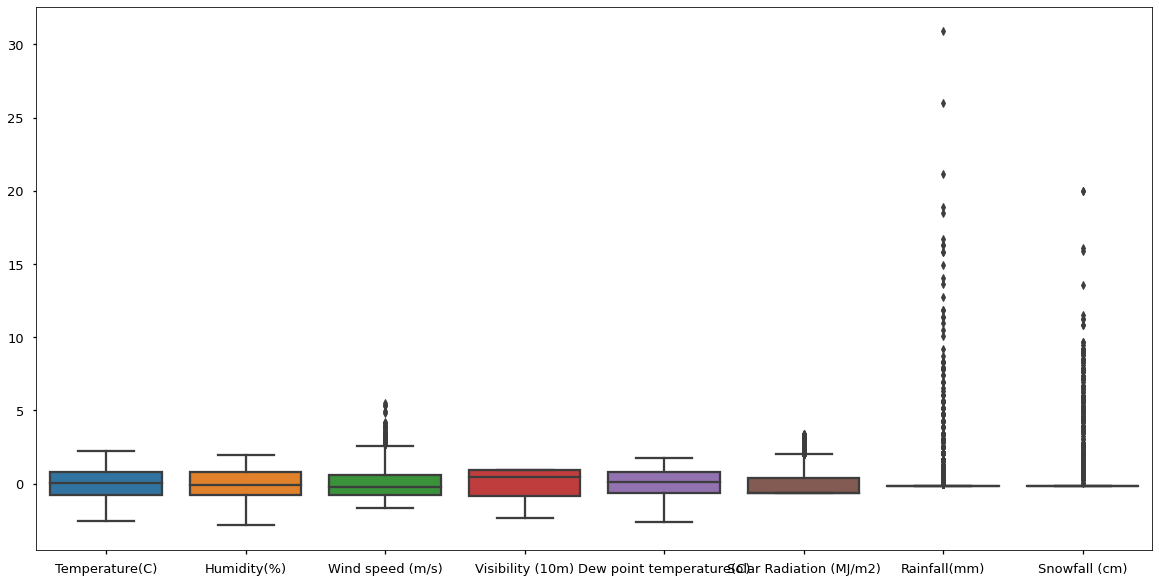

In [12]:
plt.figure(figsize=(20,10))
sns.boxplot(data=std_num_df)
plt.show()

##### Notes:

* Rainfall & Snowfall features are heavily skewed to the right.
* Wind Speed & Solar Radation features contain outliers. It may impact the regression and needs attention.

#### 2.6 Check for multicollinearity

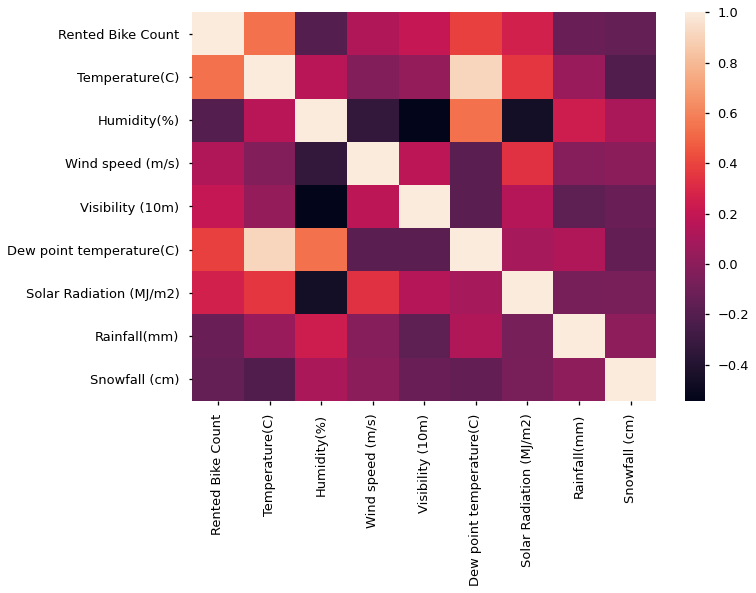

In [13]:
sns.heatmap(data.corr())
plt.show()

In [14]:
corr = data.corr()
corr.stack()[(np.abs(corr.stack()) > 0.3) & (np.abs(corr.stack()) < 1)] 

Rented Bike Count         Temperature(C)              0.538558
                          Dew point temperature(C)    0.379788
Temperature(C)            Rented Bike Count           0.538558
                          Dew point temperature(C)    0.912798
                          Solar Radiation (MJ/m2)     0.353505
Humidity(%)               Wind speed (m/s)           -0.336683
                          Visibility (10m)           -0.543090
                          Dew point temperature(C)    0.536894
                          Solar Radiation (MJ/m2)    -0.461919
Wind speed (m/s)          Humidity(%)                -0.336683
                          Solar Radiation (MJ/m2)     0.332274
Visibility (10m)          Humidity(%)                -0.543090
Dew point temperature(C)  Rented Bike Count           0.379788
                          Temperature(C)              0.912798
                          Humidity(%)                 0.536894
Solar Radiation (MJ/m2)   Temperature(C)              0

##### Notes:
* Correlation above abs(0.7) is highly correlated
* Correlation between abs(0.5) & abs(0.7) is moderatly correlated
* Correlation between abs(0.3) & abs(0.5) is a low correlation


* Temperature & Dew point temperature are highly correlated which can cause problem in computing the regression. Let's drop Dew point temperature as it is less correlated with the target variable (Rented Bike Count).

In [15]:
data.drop('Dew point temperature(C)', axis=1, inplace=True)

#### 2.7 Check variables distributions

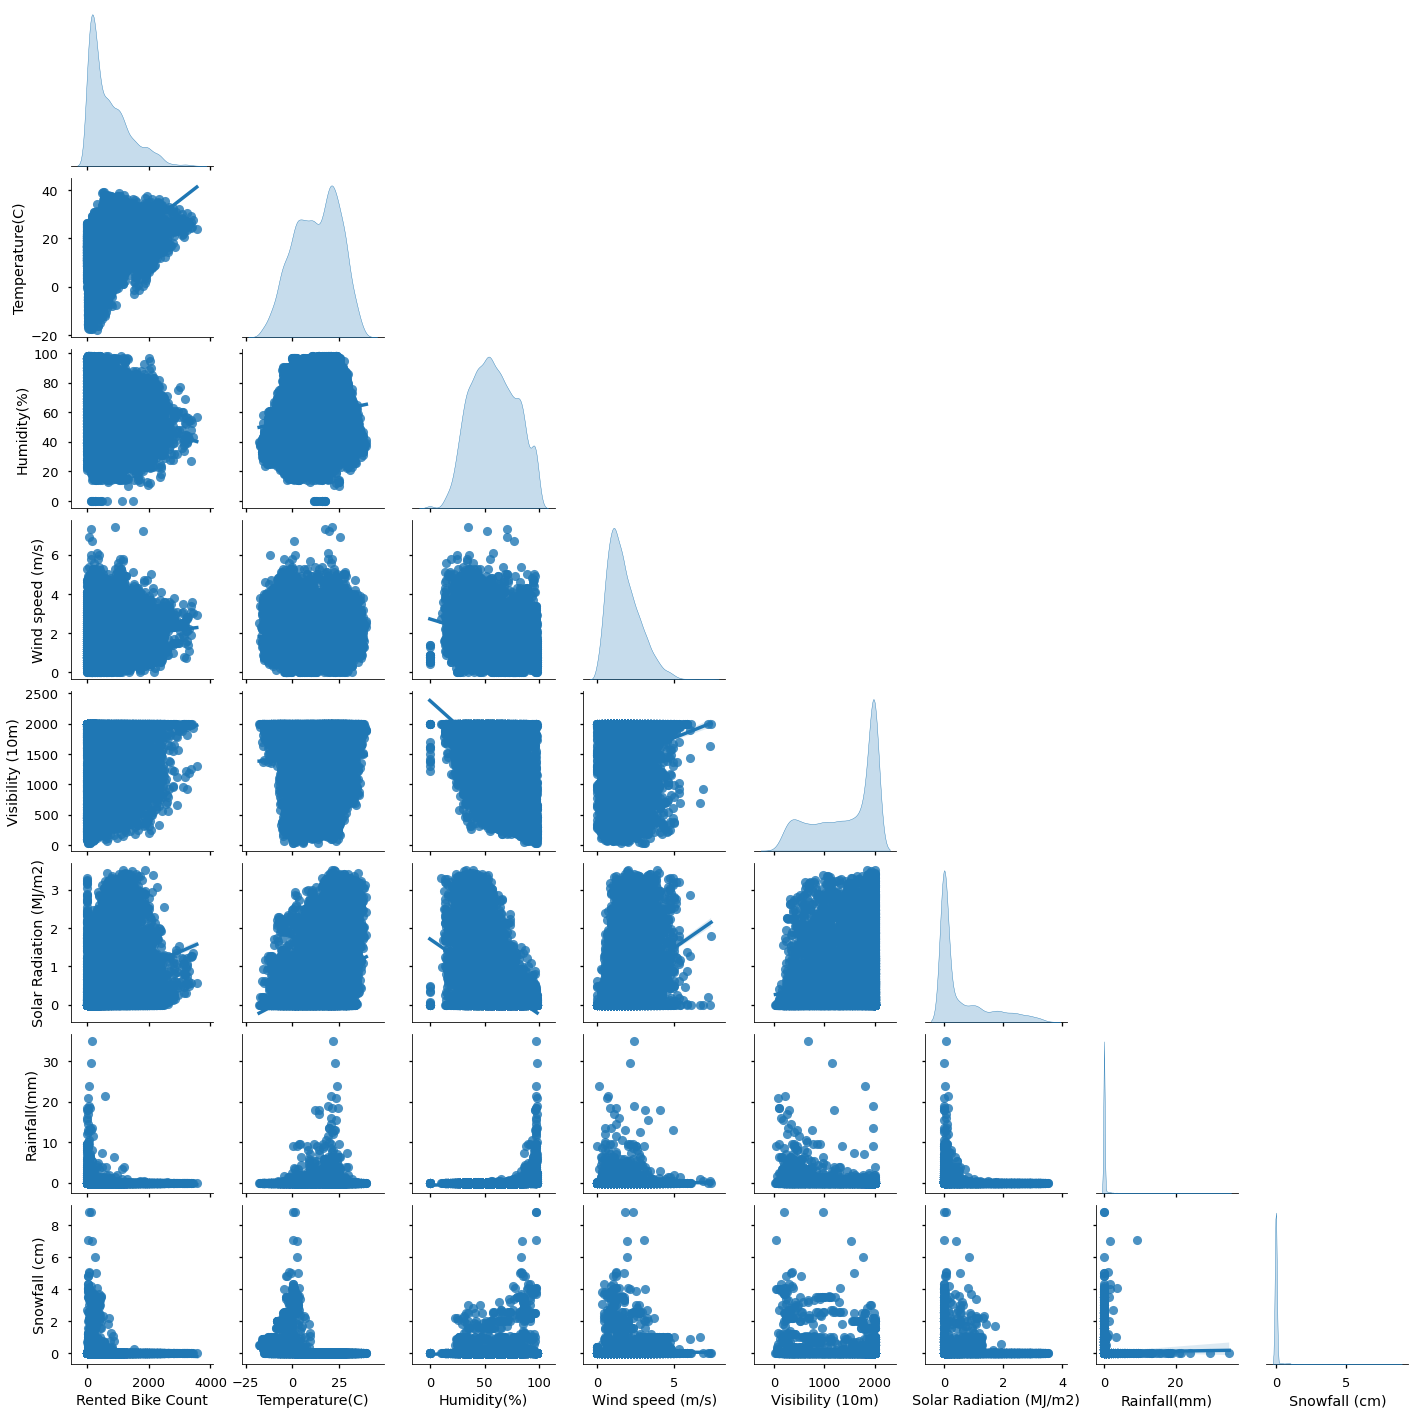

In [16]:
sns.pairplot(data.select_dtypes(exclude='object'), kind="reg", diag_kind="kde", corner=True)
plt.show()

##### Notes:

* As pointed before, a few variables are heavily skewed (right or left):
    * Rainfall (left)
    * Snowfall (left)
    * Solar radiation (left)
    * Visiblity (right)
    * Rented Bike count (left)
* Because the dataset is composed of highly skewed variables, it's preferable to use specific evaluation metrics which are less sensitive to values far from the mean. For example, mean_absolute_error or median_absolute_error.

### 3. Features engineering
   3.1 Train/Test split<br>
   3.2 Add dates features: Year, Month, Day of Week<br>
   3.3 Pipeline creation<br>
   3.4 Pipeline testing<br>

#### 3.1 Train / Test split

In [17]:
# Checkin shape
print(f'Dataset shape: {data.shape}')

# Split Features and Predicted variable
y = data['Rented Bike Count']
X = data.loc[:, data.columns != 'Rented Bike Count']

# Checkin y / predicted variable shape
print(f'Predicted variable / y shape: {y.shape}') 
# Checkin X / features / predictors
print(f'Features shape / X: {X.shape}') 

Dataset shape: (8760, 13)
Predicted variable / y shape: (8760,)
Features shape / X: (8760, 12)


In [18]:
# Split in Train / Test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=72)

# Check if shape correspond
print('Verify if X (features) and y (target/class) arrays have the same number of rows and only 1 column for y.')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

Verify if X (features) and y (target/class) arrays have the same number of rows and only 1 column for y.
X_train shape: (7008, 12)
y_train shape: (7008,)
X_test shape: (1752, 12)
y_test shape: (1752,)


#### 3.2 Add dates features: Year, Month, Day of Week

In [19]:
class DateFormatter(TransformerMixin):
    """
    DateFormatter takes a dataframe composed of object columns as input and convert them to datetime format. 
    This class will be used in a pipeline later. Hence it needs a fit & transform methods.
    """
    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X, y=None):
        # assumes X is a DataFrame
        for col in X.columns:
            X[col] = pd.to_datetime(X[col],infer_datetime_format=True)
        return X
    

class DateEncoder(TransformerMixin):
    """
    DateEncoder takes a dataframe composed of datetime columns and extract year, month & day_of_week. 
    Then it return a new dataframe.
    This class will be used in a pipeline later. Hence it needs a fit & transform methods.
    """
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df_list = []
        col_names = []
        
        for col in X.columns:
            dt = X[col].dt
            tmp = pd.concat([dt.year, dt.month, dt.day_of_week], axis=1)
            df_list.append(tmp)
            col_names.append('{}_year'.format(col))
            col_names.append('{}_month'.format(col))
            col_names.append('{}_day_of_week'.format(col))
            
        df = pd.concat(df_list, axis=1)
        
        df.columns = col_names
            
        return df

#### 3.3 Pipeline creation<a name='3.2'></a>

In [20]:
# Divide dataset columns according to data type
def numeric_variables(f):
    return f.select_dtypes(exclude='object').columns

def categorical_variables(f):
    cat_vars = list(f.select_dtypes(include='object').columns)
    return [cat for cat in cat_vars if 'date' not in cat.lower()]

def date_variables(f):
    cat_vars = list(f.select_dtypes(include='object').columns)
    return [cat for cat in cat_vars if 'date' in cat.lower()]

X_train_num_var, X_test_num_var = map(numeric_variables,[X_train,X_test])
X_train_cat_var, X_test_cat_var = map(categorical_variables,[X_train,X_test])
X_train_date_var, X_test_date_var = map(date_variables,[X_train,X_test])

In [21]:
# Use Pipeline to streamline feature engineering and modelling steps
#https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first',sparse=False))])
date_transformer = Pipeline(steps=[('DateFormatter', DateFormatter())
                                   , ('DateEncoder', DateEncoder())
                                   , ('onehot', OneHotEncoder(drop='first',sparse=False))
                                  ])

#https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train_num_var),
        ('cat', categorical_transformer, X_train_cat_var),
        ('date', date_transformer, X_train_date_var)])

#### 3.4 Pipeline testing<a name='3.2'></a>

In [22]:
# Test preprocessor step
pre = Pipeline(steps=[('preprocessor',preprocessor)])
pre.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Hour', 'Seasons', 'Holiday',
                                                   'Functioning Day']),
                                          

In [23]:
# Retrieve features names after preprocessor

num_features = list(pre.named_steps['preprocessor'].transformers_[0][2])
cat_features = list(pre.named_steps['preprocessor'].transformers_[1][1]
                            .named_steps['onehot']
                            .get_feature_names_out(X_train_cat_var)
                         )
date_features = list(pre.named_steps['preprocessor'].transformers_[2][1]
                            .named_steps['onehot']
                            .get_feature_names_out()
                         )
features_names = num_features + cat_features + date_features

In [24]:
# Check dataset after preprocessing phase
X_train_pipe = pre.transform(X_train)
df_processed_features = pd.DataFrame(data=X_train_pipe)
df_processed_features.columns = features_names
df_processed_features.head()

,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Hour_1,Hour_2,Hour_3,...,Date_month_9,Date_month_10,Date_month_11,Date_month_12,Date_day_of_week_1,Date_day_of_week_2,Date_day_of_week_3,Date_day_of_week_4,Date_day_of_week_5,Date_day_of_week_6
0,-0.902435,-1.877828,-1.085786,0.586881,0.293952,-0.129475,-0.168741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.006999,1.474427,-0.604192,0.925548,-0.658394,0.307135,-0.168741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.515501,-0.053807,-0.700511,-1.338262,-0.474809,-0.129475,-0.168741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.359306,-2.863786,-1.278424,0.299178,-0.658394,-0.129475,-0.168741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.771474,1.523725,-1.182105,0.295890,-0.566601,0.307135,-0.168741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 4. Modeling
   4.1 Test & select best linear regression model<br>
   4.2 Compute model: Ridge(alpha=0.01)<br>
   4.3 Model interpretation (features importance)<br>

#### 4.1 Test & select best linear regression model

In [25]:
df_model_evaluation = pd.DataFrame()

for model in [LinearRegression()
               , Ridge(alpha=0.01), Ridge(alpha=0.1), Ridge(alpha=1)
               , Lasso(alpha=0.01), Lasso(alpha=0.1), Lasso(alpha=1)]:
    # Pipeline settings
    ols = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', model)])
    # Fit
    ols.fit(X_train,y_train)

    # Predict
    y_train_pred = ols.predict(X_train)
    y_test_pred = ols.predict(X_test)

    # Evaluate
    RMSE = np.sqrt(mean_squared_error(y_train,y_train_pred))
    MAE = mean_absolute_error(y_train,y_train_pred)
    MEAE = median_absolute_error(y_train,y_train_pred)
    r2 = r2_score(y_train,y_train_pred)
    adjusted_r2 = 1 - (1-ols.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

     # Collect evaluation
    tmp = (pd.DataFrame([[str(model),RMSE,MAE,MEAE,r2,adjusted_r2]],
                columns=['model','RMSE','MAE','MEAE','r2','adjusted_r2']))
    df_model_evaluation = pd.concat([df_model_evaluation,tmp], ignore_index=True)
    print(f'{model} completed')

LinearRegression() completed
Ridge(alpha=0.01) completed
Ridge(alpha=0.1) completed
Ridge(alpha=1) completed
Lasso(alpha=0.01) completed
Lasso(alpha=0.1) completed
Lasso(alpha=1) completed


In [26]:
df_model_evaluation.sort_values(by='MAE',ascending=True)

,model,RMSE,MAE,MEAE,r2,adjusted_r2
5,Lasso(alpha=0.1),352.517260,267.943246,208.039693,0.704781,0.704274
3,Ridge(alpha=1),352.504666,268.052432,208.931932,0.704802,0.704295
4,Lasso(alpha=0.01),352.500973,268.075354,208.675236,0.704808,0.704302
2,Ridge(alpha=0.1),352.500848,268.087180,208.840742,0.704808,0.704302
1,Ridge(alpha=0.01),352.500808,268.091104,208.808005,0.704808,0.704302
0,LinearRegression(),352.501508,268.097605,208.789062,0.704807,0.704301
6,Lasso(alpha=1),354.121895,268.135301,208.402784,0.702087,0.701576


##### Notes:

* Because the dataset is composed of highly skewed variables, it's preferable to use specific evaluation metrics which are less sensitive to outliers. For example, mean_absolute_error or median_absolute_error.
* The model yields a r2 of 0.7. In other words, the predictors or independent variables explain 70% of the variability of the dependent variable (Rented Bike count). 

#### 4.2 Compute model: Ridge(alpha=0.01)

In [27]:
%%time
# Pipeline settings
ols = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', Ridge(alpha=0.01))])
# Fit
ols.fit(X_train,y_train)

# Predict
y_train_pred = ols.predict(X_train)
y_test_pred = ols.predict(X_test)

CPU times: user 217 ms, sys: 38 ms, total: 255 ms
Wall time: 121 ms


#### 4.3 Model interpretation (features importance)

In [28]:
# Extract coeffecients from linear regression equation
coefficients = ols.named_steps['regressor'].coef_
feature_coefficients = list(zip(features_names,coefficients))

In [29]:
feature_coefficients = pd.DataFrame({'features':features_names,'coef':coefficients,'abs_coef':np.abs(coefficients)})
feature_coefficients.sort_values(by='abs_coef',ascending=True, inplace=True)

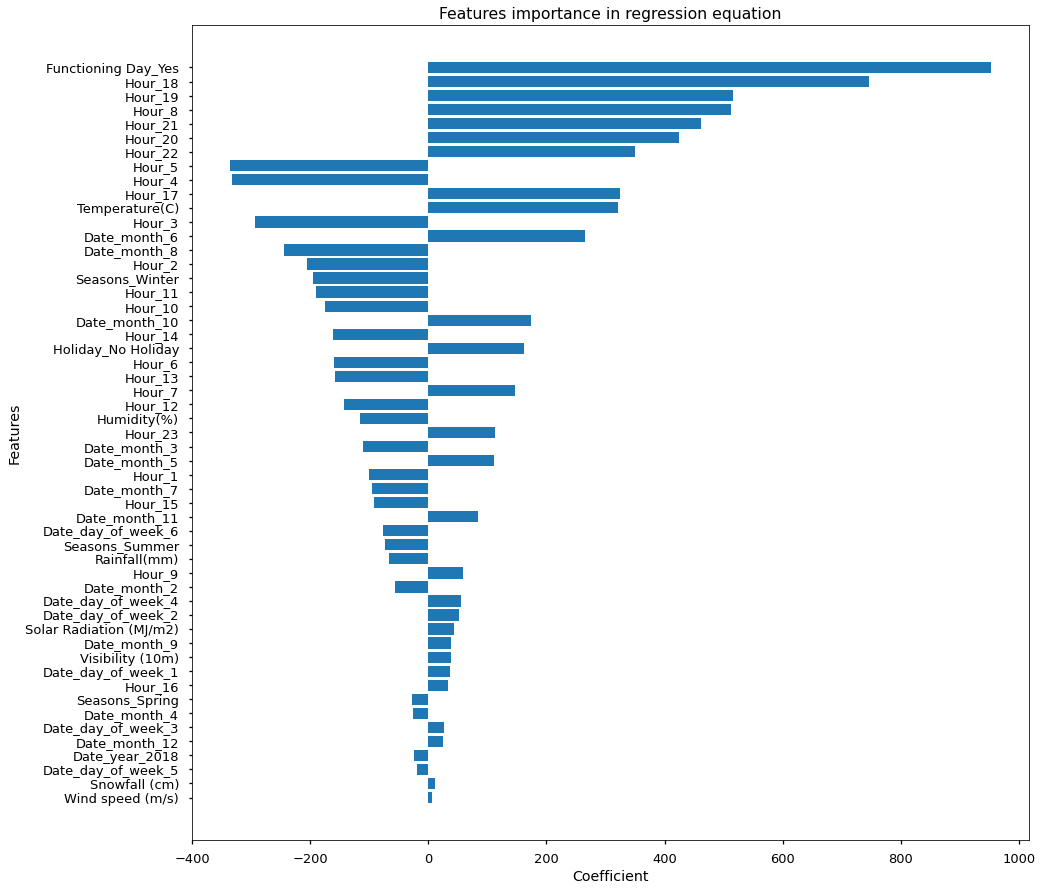

In [30]:
plt.figure(figsize=(15,15))
bar_height=feature_coefficients.coef
plt.barh(y=feature_coefficients.features,width=bar_height)
plt.title('Features importance in regression equation')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.show()

##### Notes:

* The most important feature is, unsurprisingly, if the bike sharing service is functioning or not.
* Next, most features are related to the hour of the day. Understandably, evening and morning hours at high predictors of higher bike sharing usage. Corresponding to usual peak hours traffic.
* Other than date related features, higher temperatures influence positively the bike sharing usage. 
* Also, non holidays translate in higher consumption. Meaning the bike usage is largely used by commuters.
* Finally, Humidity influences negatively the bike sharing consumption. An interesting point is that humidity has more weight than rainfall. Meaning that typically, high humidity discourages users to rent bicycles.

### 5. Model evaluation

   5.1 Model predictive power across train & test<br>
   5.2 Linearity<br>
   5.3 Normality<br>
   5.4 Multicollinearity<br>
   5.5 Homoscedasticity<br>

#### 5.1 Model predictive power across train & test

In [31]:
df_dataset_evaluation = pd.DataFrame()

for data in [(X_train,y_train,'train'),(X_test,y_test,'test')]:
    
    X_data = data[0]
    y_data = data[1]
    data_set = data[2]

    # Pipeline settings
    ols = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', Ridge(alpha=0.01))])
    # Fit
    ols.fit(X_data,y_data)

    # Predict
    y_pred = ols.predict(X_data)

    # Evaluate
    RMSE = np.sqrt(mean_squared_error(y_data,y_pred))
    MAE = mean_absolute_error(y_data,y_pred)
    MEAE = median_absolute_error(y_data,y_pred)
    r2 = r2_score(y_data,y_pred)
    adjusted_r2 = 1 - (1-ols.score(X_data,y_data))*(len(y_data)-1)/(len(y_data)-X_data.shape[1]-1)

     # Collect evaluation
    tmp = (pd.DataFrame([[str(data_set),RMSE,MAE,MEAE,r2,adjusted_r2]],
                columns=['model','RMSE','MAE','MEAE','r2','adjusted_r2']))
    df_dataset_evaluation = pd.concat([df_dataset_evaluation,tmp], ignore_index=True)
    print(f'{data_set} completed')

train completed
test completed


In [32]:
df_dataset_evaluation.sort_values(by='MAE',ascending=True)

,model,RMSE,MAE,MEAE,r2,adjusted_r2
1,test,346.116962,260.683065,194.159153,0.696703,0.694610
0,train,352.500808,268.091104,208.808005,0.704808,0.704302


##### Notes:

As expected, the model lost a bit of its predictive power on test data. However, the reduction in r2 is minor. Thus, the model generalize well the relationships between these variables.

#### 5.2 Linearity

The model assumes a linear relationship between target (dependent variable) and predictors (independent variables). In the case of a multi linear regression, we can verify the linear relationship between target and predicted values.

As shown below, there is indeed a linear relationship between both.

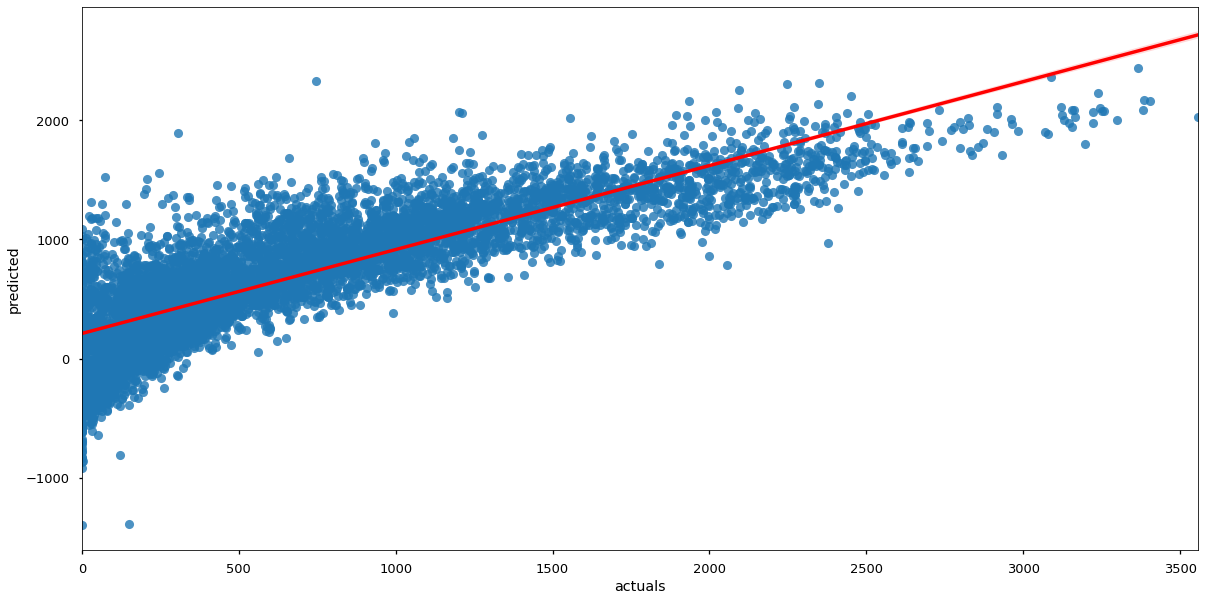

In [33]:
reg_data = pd.DataFrame({'actuals':y_train,'predicted':y_train_pred})
plt.figure(figsize=(20,10))
sns.regplot(x="actuals"
            , y='predicted'
            , data=reg_data
            , seed=42
            , truncate=True
            , line_kws={"color": "red"})
plt.show()

#### 5.3 Normality

The model assumes that the residuals (difference between target and predicted values) are normally distributed. If so, it means the model is complete and captures the full relationship between target and predictor variables.

As shown below, the residuals are normally distributed. However, there is slight divergence for extreme values which indicate the model could be improved.

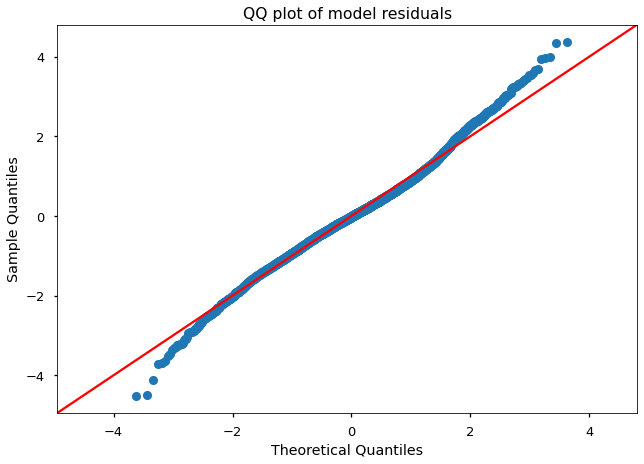

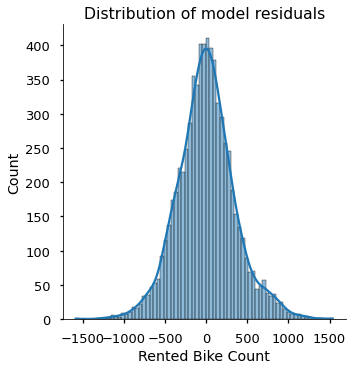

In [34]:
residuals = y_train - y_train_pred
sm.qqplot(residuals, fit='True',line='45')
plt.title('QQ plot of model residuals')
plt.show()
sns.displot(residuals,kde='true')
plt.title('Distribution of model residuals')
plt.show()

#### 5.4 Multicollinearity

We've already check multicollinearity prior building the model. As a reminder, we exclude 1 column with correlation with another predictor. 

#### 5.5 Homoscedasticity

The model assumes that the residuals have equal and uniform variance for all predicted values.

As shown below, the variance of our residuals is mostly uniform and equal across prediction. Once again, the model could be improve for days with low rented bike count. In other words, some relationship are not entirely captured by this model.

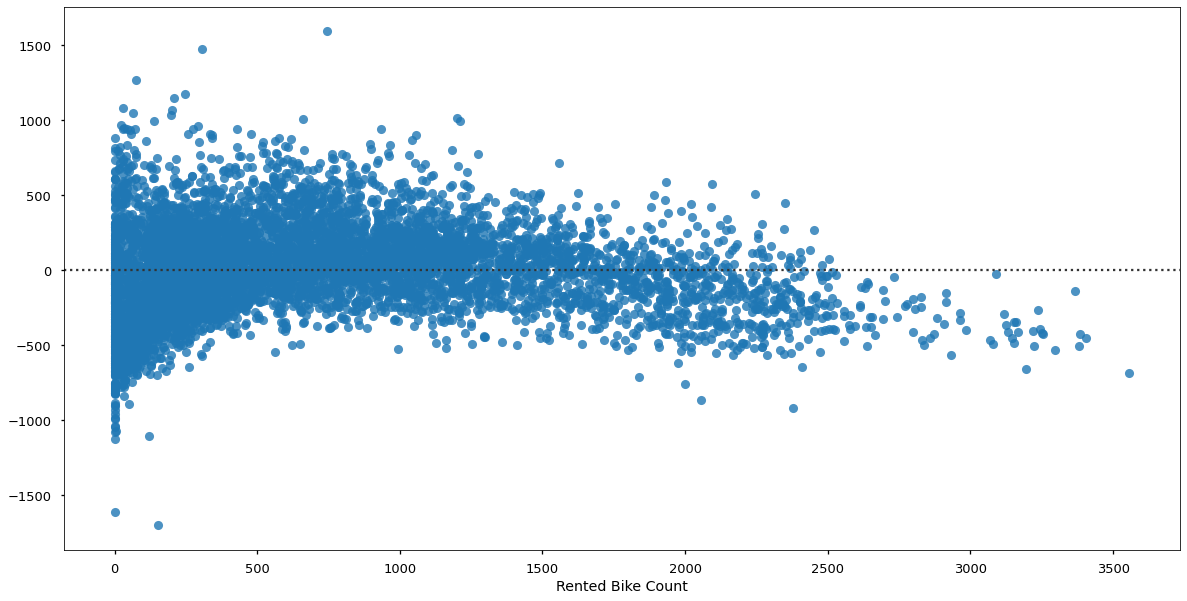

In [35]:
plt.figure(figsize=(20,10))
sns.residplot(x=y_train, y=y_train_pred)
plt.show()

### 6. Conclusion

This notebook demonstrates that the Rented Bike count in Seoul can be expressed and predicted based on a Multiple Linear Regression model. 

In terms of pure predictive power, the final linear model proposed captures 70% of the variability in the number of bike rented per day. After a careful model evaluation, a few signs show that the model can be improved - especially for days with low demand.

After analyzing the features importance, we know that the number of rented bike is highly influenced by the hour of day, month of the year and temperature. Other features related to the meteorological conditions are also taken into account. 

Thanks to a number of insights collected by analyzing the model, we can extrapolate a few hypothesis. For example, the rental service shows a strong demand on typical office hours peaks. Hence, the service is used by commuters. Based on this, we could propose further investigations on customer satisfication dedicated towards commuters. In parallel, a market analysis could focus on the value proposition for other customer segments like tourists.

---
# The End